In [11]:
pip install watermark

  Using cached watermark-2.0.2-py2.py3-none-any.whl (5.3 kB)
Note: you may need to restart the kernel to use updated packages.


In [12]:
%load_ext watermark

In [13]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn

CPython 3.7.6
IPython 7.12.0

numpy 1.18.1
scipy 1.4.1
pandas 1.0.1
matplotlib 3.1.3
sklearn 0.22.1

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 8
interpreter: 64bit


UsageError: Line magic function `%vw` not found.


In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
class SGDRegressor(BaseEstimator):
    
    def __init__(self, eta=1e-3, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
        w = np.zeros(X.shape[1])
        
        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):
                
                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]  
                w = new_w.copy()
                
                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))
                
        self.w_ = self.weights_[np.argmin(self.mse_)]
                
        return self
                  
    def predict(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
        return X.dot(self.w_)

In [3]:
data_demo = pd.read_csv('../Desktop/Dataset/weights_heights.csv')

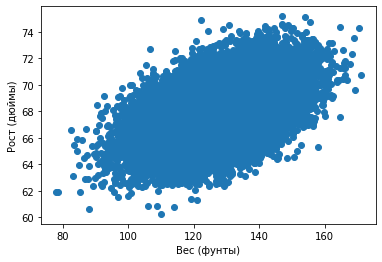

In [4]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [31]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

In [34]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train_scaled, y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.22s/it]


SGDRegressor(eta=0.001, n_iter=10)

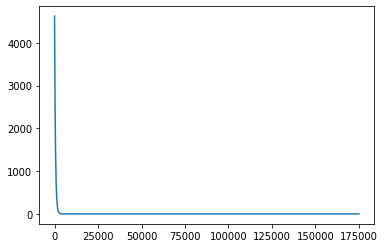

In [35]:
plt.plot(sgd_reg.mse_)

In [12]:
min(sgd_reg.mse_)

2.7151352406643627

In [13]:
sgd_reg.w_

array([67.9898497 ,  0.94447605])

In [53]:
plt.plot(sgd_reg.w)

AttributeError: 'SGDRegressor' object has no attribute 'w'

In [14]:
mean_squared_error(y_valid, sgd_reg.predict(X_valid_scaled))

2.6708681207033784

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
ln_reg = LinearRegression()
ln_reg.fit(X_train_scaled, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [398, 25000]

In [17]:
mean_squared_error(y_valid, ln_reg.predict(X_valid_scaled))

2.670830767667635

Вопрос 1. В каком знаке после разделителя отличаются MSE линейной регрессии и SGDRegressor для отложенной выборки?

* 5

Вопрос 2. По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?

* w(t+1)j=w(t)j+η(Cyixijσ(−yiwTxi)−δj≠0wj)

In [36]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [37]:
class SGDClassifier(BaseEstimator):
    
    def __init__(self, C=1, eta=1e-3, n_iter=10):
        self.eta = eta
        self.C = C
        self.n_iter = n_iter
        self.loss_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        best_loss = np.inf
        w = np.zeros(X.shape[1])
        
        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):
                
                new_w = w.copy()
                new_w[0] += self.eta * self.C * y[i] * sigma( -y[i] *  w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (self.C * y[i] * X[i, j] *
                                            sigma(-y[i] * w.dot(X[i, :]))
                                            -  w[j])
                w = new_w.copy()
                
                self.weights_.append(w)
                self.loss_.append(log_loss(y, sigma(X.dot(w))))
                
        self.w_ = self.weights_[np.argmin(self.loss_)]
                
        return self
        
    def predict_proba(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        p_vec = sigma(X.dot(self.w_)).reshape([X.shape[0], 1])
        return np.hstack([1 - p_vec, p_vec])
    
    def predict(self, X):
        pred_probs = self.predict_proba(X)[:, 1]
        signs = np.sign(pred_probs - 0.5) 
        # но могли остаться нули, если значения в pred_probs = 0.5 в точности
        signs[np.where(signs == 0)] = 1
        return signs

In [38]:
from sklearn.datasets import load_breast_cancer

In [39]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [42]:
sgd_clf = SGDClassifier(C=1, eta=1e-3, n_iter=3)
sgd_clf.fit(X_train_scaled, y_train)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.56it/s]


SGDClassifier(C=1, eta=0.001, n_iter=3)

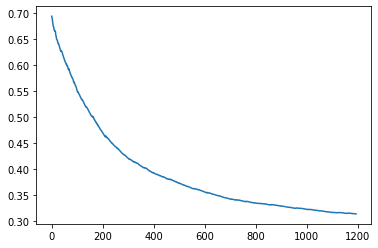

In [43]:
plt.plot(sgd_clf.loss_)

In [44]:
sgd_clf = SGDClassifier(C=100, eta=1e-3, n_iter=10)
sgd_clf.fit(X_train_scaled, y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.57it/s]


SGDClassifier(C=100, eta=0.001, n_iter=10)

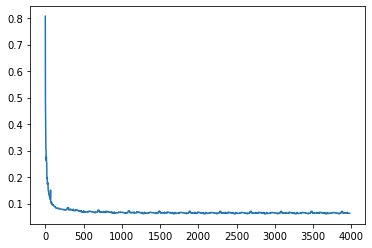

In [45]:
plt.plot(sgd_clf.loss_)

In [46]:
min(sgd_clf.w_)

-0.8564067383805151

In [47]:
best_w = sgd_clf.weights_[np.argmin(sgd_clf.loss_)]

In [48]:
np.min(best_w), np.max(best_w)

(-0.8564067383805151, 0.6254222654788522)

In [49]:
pd.DataFrame({'coef': best_w,
             'feat': ['intercept'] + list(cancer.feature_names)}).sort_values(by='coef')

,coef,feat
11,-0.856407,radius error
27,-0.761531,worst concavity
22,-0.663732,worst texture
13,-0.631904,perimeter error
21,-0.631478,worst radius
8,-0.587433,mean concave points
14,-0.586984,area error
7,-0.584652,mean concavity
29,-0.568836,worst symmetry
24,-0.564085,worst area


In [50]:
cancer.feature_names[np.argmin(best_w) - 1]

'radius error'

In [51]:
log_loss(y_valid, sgd_clf.predict(X_valid_scaled))

0.6059574735498409

In [52]:
roc_auc_score(y_valid, sgd_clf.predict(X_valid_scaled) )

0.9754098360655737

In [53]:
log_loss(y_valid, sgd_clf.predict_proba(X_valid_scaled)[:, 1])

0.09281325383557748

In [54]:
roc_auc_score(y_valid, sgd_clf.predict_proba(X_valid_scaled)[:,1])

0.9913561847988077

Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с sklearn.linear_model.LogisticRegression (параметры по умолчанию, только random_state=17) и сравните результаты.

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
lg_reg = LogisticRegression(random_state=17)
lg_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=17, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
log_loss(y_valid, lg_reg.predict_proba(X_valid_scaled)[:, 1])

0.10855223162447165

In [66]:
roc_auc_score(y_valid, lg_reg.predict_proba(X_valid_scaled)[:,1])

0.9885245901639343

### 3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

In [74]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [75]:
reviews_train = load_files("../Desktop/imdb_reviews/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [76]:
reviews_test = load_files("../Desktop/imdb_reviews/test")
text_test, y_test = reviews_test.data, reviews_test.target

In [77]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

Wall time: 27.4 s


In [78]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

In [83]:
%%time
lg_reg.fit(X_train, y_train)

Wall time: 33.1 s


C:\Users\maksn_000\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=17, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [111]:
roc_auc_score(y_test, lg_reg.predict_proba(X_test)[:,1])

0.9577015168

Вопрос 4. Чем sklearn-реализация стохастического классификатора более продвинута, чем SGDClassifier, который мы реализовали? Отметьте все подходящие варианты.

* Изменяемый шаг градиентного спуска
* Реализован линейный SVM
* Реализована ранняя остановка во избежание переобучения
* Есть распараллеливание по процессорам
* Можно обучать LASSO
* Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному)

In [114]:
%%time
sgd_cl = SGDClassifier(max_iter=100, random_state=17, n_jobs=-1)
sgd_cl.fit(X_train, y_train)

Wall time: 1.35 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=17, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [117]:
sgd_cl = SGDClassifier(loss='log', max_iter=100, random_state=17, n_jobs=-1)

Wall time: 1.33 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=100,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [119]:
%%time
sgd_cl.fit(X_train, y_train)

Wall time: 1.3 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=100,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [122]:
roc_auc_score(y_test, sgd_cl.predict_proba(X_test)[:,1])

0.9519741536

Вопрос 5. В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора Sklearn с логистической функцией потерь?

* 3